# <I>Loading data

In [3]:
#DataSource: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
#https://data.mendeley.com/datasets/rscbjbr9sj/2
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale = 1/255.)
train_data = datagen.flow_from_directory(
             '/content/drive/MyDrive/chest_xray/train',
             target_size=(128, 128),
             batch_size=32,
             color_mode = 'grayscale',
             class_mode='binary')

Found 5216 images belonging to 2 classes.


In [4]:
test_data = datagen.flow_from_directory(
             '/content/drive/MyDrive/chest_xray/test',
             target_size=(128, 128),
             batch_size=32,
             shuffle = False,
             color_mode = 'grayscale',
             class_mode='binary')

val_data = datagen.flow_from_directory(
             '/content/drive/MyDrive/chest_xray/val',
             target_size=(128, 128),
             batch_size=32,
             shuffle = False,
             color_mode = 'grayscale',
             class_mode='binary')

Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [5]:
from keras.layers import Conv2D,  MaxPooling2D, AveragePooling2D, Input, Dense, BatchNormalization, Flatten, Concatenate, Dropout
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import plot_model, to_categorical
from keras import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:

inputs = Input(shape=(128,128,1))
x = Conv2D(128,2, activation='relu')(inputs)
x = AveragePooling2D((2,2))(x)
x = Conv2D(64,2, activation='relu')(x)
x = MaxPooling2D((2,2))(x)
#x = Flatten()(x)
x = Dense(32, activation = 'relu')(x)
#concat = Concatenate(axis=1)([conv,conv2])
x = AveragePooling2D()(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.5)(x)
x = Conv2D(16,2, activation='relu')(x)
x = BatchNormalization()(x)
flatten = Flatten()(x)
out = Dense(1, activation = 'sigmoid')(flatten)

model = Model(inputs,out)
model.summary()

model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 127, 127, 128)     640       
_________________________________________________________________
average_pooling2d (AveragePo (None, 63, 63, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        32832     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
dense (Dense)                (None, 31, 31, 32)        2080      
_________________________________________________________________
average_pooling2d_1 (Average (None, 15, 15, 32)        0     

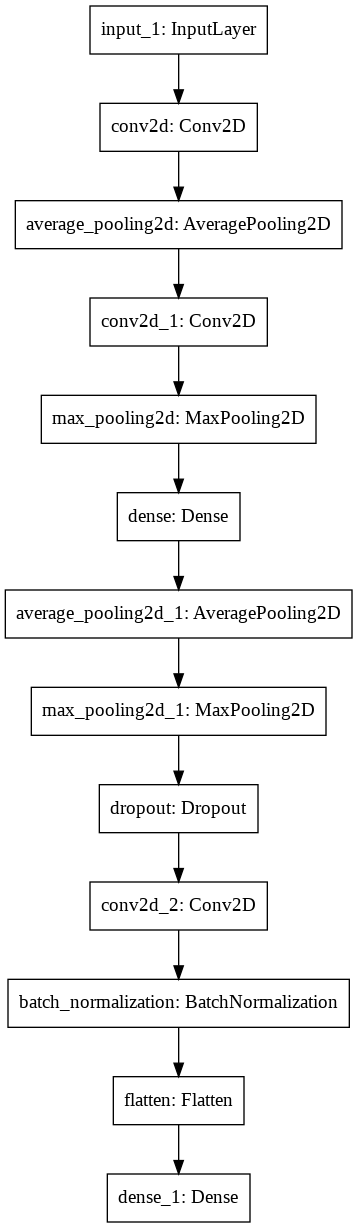

In [7]:
plot_model(model)

In [8]:
y_test = np.concatenate((np.zeros((234,1)),np.ones((390,1))))

In [9]:
import tensorflow as tf
from sklearn.metrics import f1_score, roc_auc_score
validation_data=(test_data,y_test)
class Metrics(tf.keras.callbacks.Callback):
  def __init__(self):
    super().__init__()
    
  def on_train_begin(self, logs={}):
    self.f1_Score = []
    self.auc = []
  
  def on_epoch_end(self, epoch, logs={}):
   
    val_predict_round = np.asarray(self.model.predict(validation_data[0])).round()
    val_predict = np.asarray(self.model.predict(validation_data[0]))
    val_targ = validation_data[1]
    
    f1 = f1_score(val_targ, val_predict_round,average='micro')
   
    self.f1_Score.append(f1)
    self.auc.append(roc_auc_score(val_targ,val_predict))
    print('— val_f1_score: {0} — auc: {1}'.format(f1, roc_auc_score(val_targ,val_predict)))
    return
 
metrics = Metrics()

In [37]:
history = model.fit_generator(train_data,
                         epochs = 10,
                         validation_data = test_data,
                         callbacks=[metrics])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
163/163 [==============================] - 51s 311ms/step - loss: 0.1067 - accuracy: 0.9571 - val_loss: 0.6467 - val_accuracy: 0.7804
— val_f1_score: 0.780448717948718 — auc: 0.9278216085908394
Epoch 2/10
163/163 [==============================] - 50s 307ms/step - loss: 0.1034 - accuracy: 0.9595 - val_loss: 0.4867 - val_accuracy: 0.8205
— val_f1_score: 0.8205128205128205 — auc: 0.9368507560815253
Epoch 3/10
163/163 [==============================] - 50s 306ms/step - loss: 0.0944 - accuracy: 0.9622 - val_loss: 0.8895 - val_accuracy: 0.7388
— val_f1_score: 0.7387820512820513 — auc: 0.9377218934911242
Epoch 4/10
163/163 [==============================] - 51s 311ms/step - loss: 0.0950 - accuracy: 0.9634 - val_loss: 1.1133 - val_accuracy: 0.7083
— val_f1_score: 0.7083333333333334 — auc: 0.9239918912995836
Epoch 5/10
163/163 [==============================] - 50s 308ms/step - loss: 0.0965 - accuracy: 0.9599 - val_loss: 1.4517 - val_accuracy: 0.6795
— val_f1_score: 0.67948717948717

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


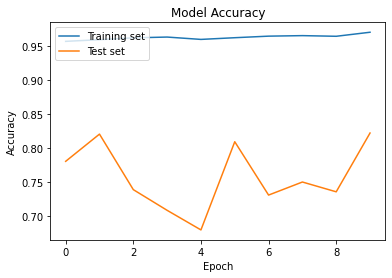

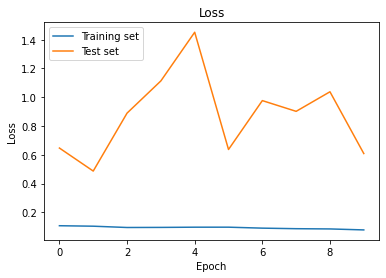

In [38]:
#Accuracy
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Test set'], loc='upper left')
plt.show()

#Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Test set'], loc='upper left')
plt.show()

In [12]:
test = model.predict(test_data)

In [13]:
test = test.round()

In [ ]:
test

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
for i in model.layers:
  print(i.name)

input_1
conv2d
average_pooling2d
conv2d_1
max_pooling2d
dense
average_pooling2d_1
max_pooling2d_1
dropout
conv2d_2
batch_normalization
flatten
dense_1


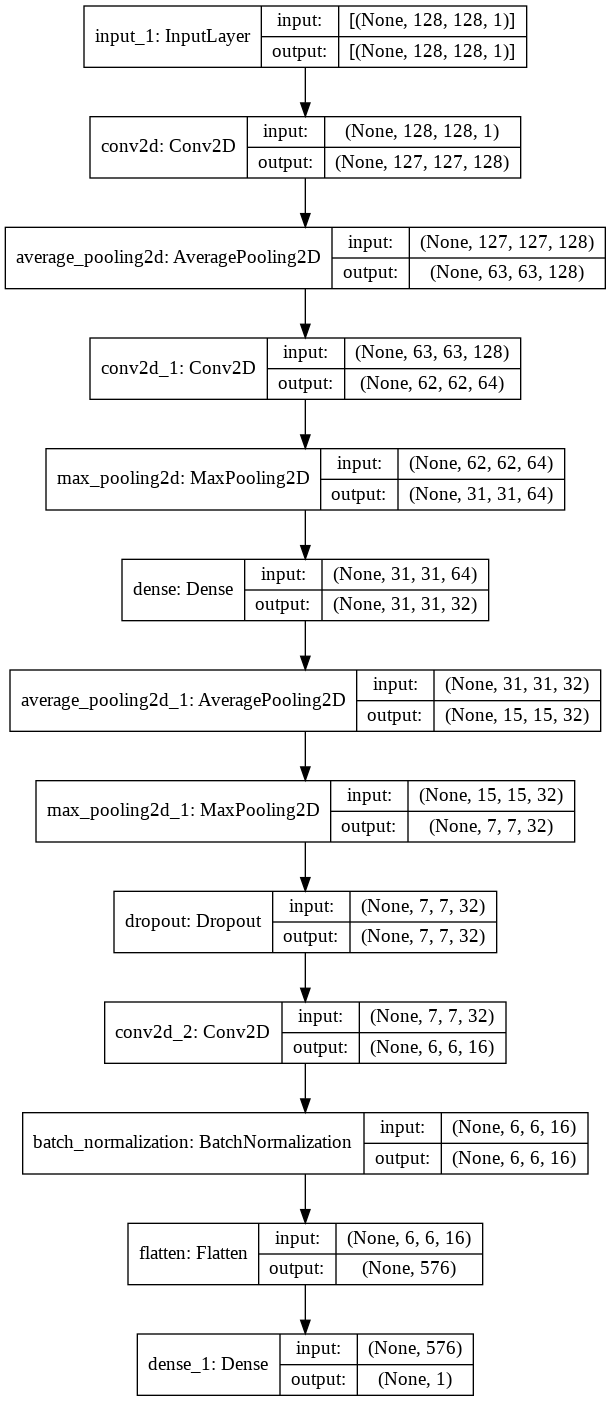

In [40]:
plot_model(model,show_shapes=True)

In [41]:
#source: https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/
def visualize_kernels_performance(layer_number,test_img,trained_model): 
  from keras import Model
  print('Plotting kernel performance for layer : '+ str(trained_model.layers[layer_number].name),'\n','*'*100)
  ixs = [layer_number]
  outputs = [model.layers[i].output for i in ixs]
  mod = Model(inputs=trained_model.inputs, outputs=outputs)
  
  bn_out = mod.predict(test_img.reshape(1,128,128,1))

  rows = 8
  cols = 4
  #for fmap in bn_out:
  # plot all 64 maps in an 8x8 squares
  plt.figure(figsize=(15,10))
  #plt.imshow(tf.reshape(test_img,(28,28)))
  fmap = bn_out
  ix = 1
  for _ in range(rows):
    for _ in range(2):
      ax = plt.subplot(rows, cols, ix)
      ax.set_xticks([])
      ax.set_yticks([])
      ax.set_title('kernel:'+str(ix))
      plt.imshow(fmap[0, :, :, ix-1],cmap='gray')
      ix += 1
  plt.show()
  return bn_out

In [19]:
normal_img = datagen.flow_from_directory('/content/drive/MyDrive/chest_xray/val', shuffle = False,class_mode='binary',target_size=(128,128),color_mode='grayscale')

Found 16 images belonging to 2 classes.


In [20]:
normal_img

In [21]:
test_img = load_img('/content/63018tn.jpg', color_mode='grayscale',target_size=(128,128,1))

In [22]:
test_img = img_to_array(test_img)
test_img *= 1/255. 
test_img.shape

(128, 128, 1)

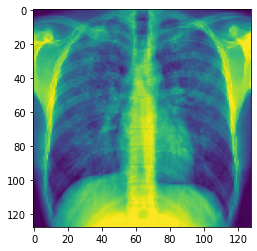

In [23]:
plt.imshow(test_img.reshape(128,128))

In [24]:
history.history

{'accuracy': [0.8080905079841614,
  0.9060583114624023,
  0.9321318864822388,
  0.9382668733596802,
  0.9472776055335999,
  0.9518788456916809,
  0.9507285356521606,
  0.9528374075889587,
  0.9570552110671997,
  0.9574386477470398],
 'loss': [0.4008552134037018,
  0.22439870238304138,
  0.1730125993490219,
  0.14825178682804108,
  0.13564079999923706,
  0.1269948035478592,
  0.12357552349567413,
  0.1189490482211113,
  0.11330430209636688,
  0.10745617002248764],
 'val_accuracy': [0.8253205418586731],
 'val_loss': [0.583877444267273]}

In [25]:
print(history.history['val_accuracy'])

[0.8253205418586731]


In [26]:
val_pred = model.predict(normal_img)

In [ ]:
val_pred.round()

In [28]:
val_tar = np.array([0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1]).reshape(16,1)
val_tar.shape

(16, 1)

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
mat = confusion_matrix(val_pred.round(),val_tar)
#sns.heatmap(max)
#plt.show()
mat

array([[1, 0],
       [7, 8]])

In [30]:

img_0 = load_img('/content/drive/MyDrive/chest_xray/val/NORMAL/NORMAL2-IM-1431-0001.jpeg', target_size=(128,128), color_mode='grayscale')

In [31]:
img_1 = load_img('/content/drive/MyDrive/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg',target_size=(128,128), color_mode='grayscale')

In [32]:
img_0 = img_to_array(img_0)
img_0 *= 1/255.
img_1 = img_to_array(img_1)
img_1 *= 1/255.

Plotting kernel performance for layer : max_pooling2d 
 ****************************************************************************************************


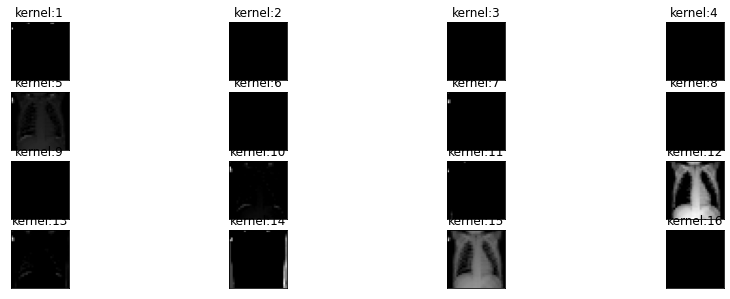

In [33]:
img_out_0 = visualize_kernels_performance(4,img_0,model)

Plotting kernel performance for layer : max_pooling2d 
 ****************************************************************************************************


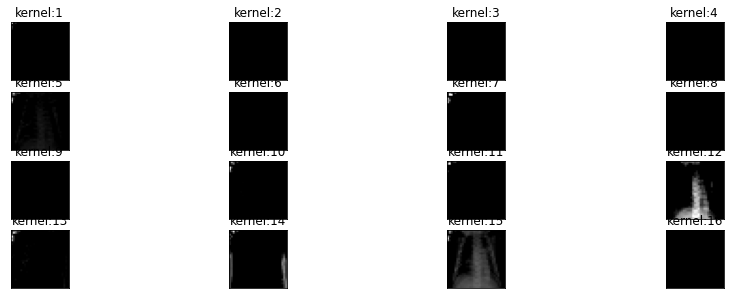

In [34]:
img_out_1 = visualize_kernels_performance(4,img_1,model)

In [57]:
def checking_layer_performance(trained_model):
  from sklearn.metrics import roc_auc_score, accuracy_score
  l = []
  for i in trained_model.layers:
    if 'conv' in i.name or 'dense' in i.name:
      l.append(model.layers.index(i))#print(i.name, model.layers.index(i))

  #l = list(range(1,len(trained_model.layers)))
  print(len(trained_model.layers), l)
  for j in range(len(l)):
    layer = l.copy()
    layer.pop(j)
    print(layer,l)
    outputs = [trained_model.layers[i].output for i in layer]
    mod = Model(inputs=trained_model.inputs, outputs=outputs)
    pred = mod.predict(test_data)
    print(pred)
    print('Dropped layer is '+str(model.layers[j].name)+' and AUC score for classification is '+str(accuracy_score(y_test,mod.predict(test_data))))
    layer = []
    mod = None
  return 

In [77]:
from sklearn.metrics import roc_auc_score, accuracy_score
l = []
for i in model.layers:
  if 'conv' in i.name or 'dense' in i.name:
    l.append(model.layers.index(i))#print(i.name, model.layers.index(i))

#l = list(range(1,len(trained_model.layers)))
#print(len(model.layers), l)

for j in l[0:-1]:
  layer = l.copy()
  layer.remove(j)
  #print(layer,l)
  outputs = [model.layers[i].output for i in layer]
  #print(outputs)
  mod = Model(inputs=model.inputs, outputs=outputs)
  print('working layers: '+str(", ".join([i.name for i in mod.layers])))
  #print('*'*100)
  #pred = mod.predict(test_data)
  #print(pred[1])
  print('Dropped layer is '+str(model.layers[j].name)+' and accuracy score for classification is '+ str(accuracy_score(y_test,np.array(mod.predict(test_data)[-1]).round()))+' and AUC score is '+str(roc_auc_score(y_test,np.array(mod.predict(test_data)[-1]))))
  print('*'*100)

working layers: input_1, conv2d, average_pooling2d, conv2d_1, max_pooling2d, dense, average_pooling2d_1, max_pooling2d_1, dropout, conv2d_2, batch_normalization, flatten, dense_1
Dropped layer is conv2d and accuracy score for classification is 0.8221153846153846 and AUC score is 0.9345441595441595
****************************************************************************************************
working layers: input_1, conv2d, average_pooling2d, conv2d_1, max_pooling2d, dense, average_pooling2d_1, max_pooling2d_1, dropout, conv2d_2, batch_normalization, flatten, dense_1
Dropped layer is conv2d_1 and accuracy score for classification is 0.8221153846153846 and AUC score is 0.9345441595441596
****************************************************************************************************
working layers: input_1, conv2d, average_pooling2d, conv2d_1, max_pooling2d, dense, average_pooling2d_1, max_pooling2d_1, dropout, conv2d_2, batch_normalization, flatten, dense_1
Dropped layer is de

KeyboardInterrupt: ignored

In [79]:
  outputs = [model.layers[i].output for i in l]
  print(outputs)
  mod = Model(inputs=model.inputs, outputs=outputs)
  for i in mod.layers:
    print(i.name)

[<KerasTensor: shape=(None, 127, 127, 128) dtype=float32 (created by layer 'conv2d')>, <KerasTensor: shape=(None, 62, 62, 64) dtype=float32 (created by layer 'conv2d_1')>, <KerasTensor: shape=(None, 31, 31, 32) dtype=float32 (created by layer 'dense')>, <KerasTensor: shape=(None, 6, 6, 16) dtype=float32 (created by layer 'conv2d_2')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_1')>]
input_1
conv2d
average_pooling2d
conv2d_1
max_pooling2d
dense
average_pooling2d_1
max_pooling2d_1
dropout
conv2d_2
batch_normalization
flatten
dense_1


In [ ]:
for i in model.layers:
  if 'conv' in i.name or 'dense' in i.name:
    print(i.name, model.layers.index(i))

In [45]:
model.predict(test_data).round().shape

(624, 1)

In [53]:
y_test.shape

(624, 1)

In [92]:
model.save('/content/drive/MyDrive/model.h5', save_format='h5')